### Setup & Read Data

In [53]:
# Imports
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from arch import arch_model
from contextlib import contextmanager
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler
from time import time
import statsmodels.api as sm

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Width of the display in characters
pd.set_option('display.max_rows', 10)       # Optional: limit number of rows
warnings.filterwarnings('ignore')

In [3]:
# Constants
DATA_DIR = "preprocessing_data/"

In [4]:
@contextmanager
def timer(name):
    start = time()
    yield
    end = time()
    print(f"{name}: {end - start:.2f} seconds")

In [5]:
# Read options prices into a dataframe
def read_dataset(directory: str, file_pattern: str, label: str) -> pd.DataFrame:
    path_pattern = os.path.join(directory, file_pattern)
    options_files = glob.glob(path_pattern)

    dfs = []
    with timer(f"{label} file reading"):
        for filename in options_files:
            try:
                df = pd.read_csv(filename, low_memory=False)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading file {filename}: {str(e)}")
                continue

        if not dfs:
            raise ValueError("No files were successfully read")

        combined_df = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined_df

### Options Data Preprocessing

In [6]:
def _clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.map(lambda x: x.strip('[] '))
    return df


def _drop_columns(df: pd.DataFrame, drop_columns: list) -> pd.DataFrame:
    for column in drop_columns:
        try:
            df = df.drop(column, axis=1)
        except KeyError as e:
            print(f"! Warning KeyError: {str(e)}")
    return df


def _drop_long_options(df: pd.DataFrame, expire_in_months: int = 36, print_distribution: bool = True) -> (pd.DataFrame, int):
    df['MTM'] = (df['EXPIRE_DATE'] - df['QUOTE_DATE']).dt.total_seconds() / (30.4375 * 24 * 60 * 60)

    if print_distribution:
        # Count records by month ranges
        month_ranges = pd.cut(df['MTM'],
                            bins=[-float('inf'), 1, 2, 3, 4, 6, 12, 24, 36, float('inf')],
                            labels=['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '3 Yr+'])

        print("\nDistribution of maturity periods:")
        distribution = month_ranges.value_counts().sort_index()
        for period, count in distribution.items():
            print(f"{period}: {count:,} records ({count/len(df)*100:.2f}%)")

    # Filter records
    df = df[df['MTM'] < expire_in_months]
    dropped_count = distribution['3 Yr+'] if print_distribution else len(df[df['MTM'] >= expire_in_months])

    return df, dropped_count


def _print_preprocessing_stats(df: pd.DataFrame, starting_row_count: int, nan_row_count: int, filtered_count: int):
    final_row_count = starting_row_count - nan_row_count - filtered_count

    print(df.columns)
    print(f"Original row count: {starting_row_count}")
    print(f"NaN row count: {nan_row_count} records ({nan_row_count/starting_row_count*100:.2f}%)")
    print(f"Filtered record count: {filtered_count} records ({filtered_count/starting_row_count*100:.2f}%)")
    print(f"Post-processed row counts: {final_row_count} records ({final_row_count/starting_row_count*100:.2f}%)")


def preprocess_options_df(df: pd.DataFrame) -> pd.DataFrame:
    with timer("Preprocessing Options Dataset..."):
        initial_row_count = len(df)

        # Remove square brackets and strip whitespace from column names
        df = _clean_column_names(df)

        # Clean options dataframe
        nan_counts = df.isna().any(axis=1).sum()
        df = df.dropna()

        # Format DateTime columns
        df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
        df['EXPIRE_DATE'] = pd.to_datetime(df['EXPIRE_DATE'])
        df = df.sort_values('QUOTE_DATE').reset_index(drop=True)

        # Drop options expiring in 3 years & redundant columns
        df, filtered_count = _drop_long_options(df)
        drop_columns = ["QUOTE_UNIXTIME", "QUOTE_READTIME", "QUOTE_TIME_HOURS", "EXPIRE_UNIX"]
        df = _drop_columns(df, drop_columns)

        _print_preprocessing_stats(df, initial_row_count, nan_counts, filtered_count)
        return df

### Rates Data Preprocessing

In [7]:
def preprocess_rates_df(df: pd.DataFrame) -> pd.DataFrame:
    with timer("Preprocessing Rates Dataset..."):
        initial_rows = len(df)
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        df['Date'] = pd.to_datetime(df['Date'])

        df = df.sort_values('Date').reset_index(drop=True)

        cutoff = pd.to_datetime('2022-04-01')
        df_filtered = df[df['Date'] >= cutoff]
        removed_rows = initial_rows - len(df_filtered)

        mask = df_filtered['4 Mo'].isna()
        df_filtered.loc[mask, '4 Mo'] = (
            df_filtered.loc[mask, '3 Mo'] * 0.667 +
            df_filtered.loc[mask, '6 Mo'] * 0.333
        )

        # Print summary
        print(f"\nDate Filtering Summary:")
        print(f"Cutoff date: {cutoff.strftime('%Y-%m-%d')}")
        print(f"Original records: {initial_rows:,}")
        print(f"Records removed: {removed_rows:,}")
        print(f"Records remaining: {len(df_filtered):,}")
        print(f"Percentage removed: {(removed_rows/initial_rows)*100:.2f}%")

        return df_filtered

### Join Datasets

In [8]:
def merge_datasets(options_df: pd.DataFrame, rates_df: pd.DataFrame) -> pd.DataFrame:
    with timer("Merging Datasets..."):
        df = pd.merge(
            options_df,
            rates_df,
            left_on='QUOTE_DATE',
            right_on='Date',
            how='left'
        )

        df = _drop_columns(df, ["Date", "5 Yr", "7 Yr", "10 Yr", "20 Yr", "30 Yr"])
        rate_columns = ['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr']
        df[rate_columns] = df[rate_columns].ffill().bfill()
        return df

### Feature Engineering

In [9]:
month_map = {
    0: '1 Mo',
    1: '1 Mo',
    2: '2 Mo',
    3: '3 Mo',
    4: '4 Mo',
    6: '6 Mo',
    12: '1 Yr',
    24: '2 Yr',
    36: '3 Yr'
}


def interpolate_rate(row):
    rates = [row[col] for col in month_map.values()]
    cs = CubicSpline([*month_map.keys()], rates)
    return cs(row['MTM'])


def get_rate(row):
    conditions = [np.floor(row['MTM']) == month for month in month_map.keys()]
    choices = [month_str for month_str in month_map.values()]
    row['MTM'] = np.select(conditions, choices, default=str(row['MTM']))
    # row['MTM'] = np.select(conditions, choices, default=row['MTM']) # This was giving a type error

    maturity_to_column = {
        '1 Mo': '1 Mo',
        '2 Mo': '2 Mo',
        '3 Mo': '3 Mo',
        '4 Mo': '4 Mo',
        '6 Mo': '6 Mo',
        '1 Yr': '1 Yr',
        '2 Yr': '2 Yr',
        '3 Yr': '3 Yr'
    }

    conditions = [row['MTM'] == maturity for maturity in maturity_to_column.keys()]
    choices = [row[rate_col] for rate_col in maturity_to_column.values()]
    return np.select(conditions, choices, default=np.nan)


def interpolate_rates(df: pd.DataFrame) -> pd.DataFrame:
    with timer("Interpolating Risk Free Rate..."):
        # Create conditions for each range
        mask_4_6 = (np.floor(df['MTM']) > 4) & (np.floor(df['MTM']) < 6)
        mask_6_12 = (np.floor(df['MTM']) > 6) & (np.floor(df['MTM']) < 12)
        mask_12_24 = (np.floor(df['MTM']) > 12) & (np.floor(df['MTM']) < 24)
        mask_24_36 = (np.floor(df['MTM']) > 24) & (np.floor(df['MTM']) < 36)

        # Combine masks
        needs_interpolation = mask_4_6 | mask_6_12 | mask_12_24 | mask_24_36

        # Initialize INTERPOLATED_RATE column
        df['RFR'] = np.zeros(df.shape[0])

        df.loc[needs_interpolation, 'RFR'] = (
            df[needs_interpolation].apply(interpolate_rate, axis=1)
        )

        df.loc[~needs_interpolation, 'RFR'] = (
            df[~needs_interpolation].apply(get_rate, axis=1)
        )

        print("\nInterpolation Summary:")
        print(f"Total rows requiring interpolation: {needs_interpolation.sum()}")
        print("Rows interpolated by range:")
        print(f"4-6 months: {mask_4_6.sum()}")
        print(f"6-12 months: {mask_6_12.sum()}")
        print(f"12-24 months: {mask_12_24.sum()}")
        print(f"24-36 months: {mask_24_36.sum()}")
        return df

In [44]:
def estimate_volatility(prices: pd.Series, window=90) -> pd.DataFrame:
    log_returns = np.log(prices / prices.shift(1))
    volatility = log_returns.rolling(window=window).std()
    annualized_vol = volatility * np.sqrt(252)
    # volatility_10d = log_returns.rolling(window=10).std() # This is for other estimators, 90 day is too smooth sometimes
    # annualized_vol_10d = volatility_10d * np.sqrt(252)
    # vol_10d = pd.DataFrame({'VOL_10D': annualized_vol_10d}, index=prices.index).fillna(method='ffill').fillna(method='bfill')
    ans_df = pd.DataFrame({'VOL_90D': annualized_vol}, index=prices.index).fillna(method='ffill').fillna(method='bfill')
    longterm_avg_vol = np.sqrt(np.mean(ans_df["VOL_90D"] ** 2)) # This is technically looking into the future but it shouldn't matter much. Technically I should get another historical dataset to set all these values with
    ans_df["LONGTERM_AVG_VOL"] = longterm_avg_vol

    # TODO Create values for vol_of_vol, strength of mean reversion, and correlation
    
    # Vol of vol
    # This is also technically looking into the future, but it's a static parameter and shouldn't add much
    vol_changes = ans_df["VOL_90D"].pct_change()
    vol_of_vol_daily = vol_changes.std()
    vol_of_vol_annual = vol_of_vol_daily * np.sqrt(252)
    ans_df["VOL_OF_VOL"] = vol_of_vol_annual

    # strength of mean reversion
    var_series = ans_df["VOL_90D"] ** 2
    var_df = pd.DataFrame({"v": var_series})
    var_df["v_lag"] = var_df["v"].shift(1)
    var_df = var_df.dropna()

    X = sm.add_constant(var_df["v_lag"].values)
    y = var_df["v"].values

    res = sm.OLS(y, X).fit()
    a_hat, b_hat = res.params

    dt = 1.0 / 252 # dt per trading day

    kappa = -np.log(b_hat) / dt

    ans_df["STR_MEAN_REVERSION"] = kappa

    # Correlation
    # var_series_10d = vol_10d["VOL_10D"] ** 2
    # dV = var_series_10d.diff()
    # rho_est = -log_returns.corr(dV)
    rho_est = -0.5 # Can't get realistic values, just using a palceholder
    ans_df["CORRELATION"] = rho_est

    return ans_df




def estimate_gjr_garch_volatility(prices: pd.Series, show_output: bool = True) -> pd.DataFrame:
    log_returns = np.log(prices / prices.shift(1)).fillna(method='ffill').fillna(method='bfill')
    returns_pct = log_returns * 100 # GG needs percentage

    # Define GJR-GARCH model with t-distribution
    model = arch_model(
        returns_pct, 
        vol='GARCH',           # Base volatility model
        p=1,                   # GARCH order
        q=1,                   # ARCH order  
        o=1,                   # Asymmetric (GJR) order
        dist='t'               # t-distribution for residuals
    )
    
    fitted_model = model.fit(disp='off', show_warning=False)
    
    # convert back from percentage
    conditional_volatility = fitted_model.conditional_volatility / 100
    annualized_volatility = conditional_volatility * np.sqrt(252)
    if show_output:
        print(gg_model.summary())
    ans_df = pd.DataFrame({'VOL_GG': annualized_volatility}, index=prices.index)

    longterm_avg_vol = np.sqrt(np.mean(ans_df["VOL_GG"] ** 2)) # This is technically looking into the future but it shouldn't matter much. Technically I should get another historical dataset to set all these values with
    ans_df["LONGTERM_AVG_VOL_GG"] = longterm_avg_vol
    
    # Vol of vol
    # This is also technically looking into the future, but it's a static parameter and shouldn't add much
    vol_changes = ans_df["VOL_GG"].pct_change()
    vol_of_vol_daily = vol_changes.std()
    vol_of_vol_annual = vol_of_vol_daily * np.sqrt(252)
    ans_df["VOL_OF_VOL_GG"] = vol_of_vol_annual

    # strength of mean reversion
    var_series = ans_df["VOL_GG"] ** 2
    var_df = pd.DataFrame({"v": var_series})
    var_df["v_lag"] = var_df["v"].shift(1)
    var_df = var_df.dropna()

    X = sm.add_constant(var_df["v_lag"].values)
    y = var_df["v"].values

    res = sm.OLS(y, X).fit()
    a_hat, b_hat = res.params

    dt = 1.0 / 252 # dt per trading day

    kappa = -np.log(b_hat) / dt

    ans_df["STR_MEAN_REVERSION_GG"] = kappa


    # Correlation
    dV = var_series.diff()
    rho_est = -log_returns.corr(dV)
    rho_est = -0.5 # Can't get realistic values, just using a palceholder
    ans_df["CORRELATION_GG"] = rho_est



    return ans_df

def create_volatility_features(df: pd.DataFrame) -> pd.DataFrame:
    with timer("Creating volatility features..."):
        daily_prices = df.groupby("QUOTE_DATE")['UNDERLYING_LAST'].first()
        volatility_df = estimate_volatility(daily_prices)
        volatility_gg = estimate_gjr_garch_volatility(daily_prices,show_output=SHOW_GG_OUTPUT)
        df = df.merge(volatility_df, left_on="QUOTE_DATE", right_index=True, how='left')
        df = df.merge(volatility_gg, left_on="QUOTE_DATE", right_index=True, how='left')
        return df
    




def average_prices(df: pd.DataFrame) -> pd.DataFrame:
    with timer("Averaging prices..."):
        df['C_BID'] = pd.to_numeric(df['C_BID'], errors='coerce')
        df['C_ASK'] = pd.to_numeric(df['C_ASK'], errors='coerce')
        df['P_BID'] = pd.to_numeric(df['P_BID'], errors='coerce')
        df['P_ASK'] = pd.to_numeric(df['P_ASK'], errors='coerce')
        
        df['CALL'] = (df['C_BID'] + df['C_ASK']) / 2
        df['PUT'] = (df['P_BID'] + df['P_ASK']) / 2
        return df
    


In [48]:
SHOW_GG_OUTPUT = False
WRITE_TO_FILE = True

# Options Data
options_df = read_dataset(DATA_DIR, "*.txt", "Options Data")
options_df = preprocess_options_df(options_df)
options_df.head()

# TODO
# Should look at adding an extra at least 90 days so volatility for the first 90 days is able to be calculated

# Rates Data
rates_df = read_dataset(DATA_DIR, "*.csv", "Rates Data")
rates_df = preprocess_rates_df(rates_df)
rates_df.head()



Options Data file reading: 12.29 seconds

Distribution of maturity periods:
1 Mo: 1,462,098 records (41.03%)
2 Mo: 498,743 records (14.00%)
3 Mo: 288,949 records (8.11%)
4 Mo: 239,953 records (6.73%)
6 Mo: 371,169 records (10.42%)
1 Yr: 439,100 records (12.32%)
2 Yr: 179,602 records (5.04%)
3 Yr: 27,548 records (0.77%)
3 Yr+: 56,372 records (1.58%)
Index(['QUOTE_DATE', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'MTM'],
      dtype='object')
Original row count: 3563534
NaN row count: 0 records (0.00%)
Filtered record count: 56372 records (1.58%)
Post-processed row counts: 3507162 records (98.42%)
Preprocessing Options Dataset...: 8.90 seconds
Rates Data file reading: 0.00 seconds

Date Filterin

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
62,2022-04-01,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,2.55,2.50,2.39,2.60,2.44
63,2022-04-04,0.18,0.42,0.66,0.81984,1.14,1.72,2.43,2.61,2.56,2.52,2.42,2.64,2.48
64,2022-04-05,0.18,0.42,0.65,0.80984,1.13,1.77,2.51,2.69,2.69,2.65,2.54,2.74,2.57
65,2022-04-06,0.21,0.44,0.67,0.82984,1.15,1.79,2.50,2.67,2.70,2.69,2.61,2.81,2.63
66,2022-04-07,0.21,0.50,0.68,0.83651,1.15,1.78,2.47,2.66,2.70,2.73,2.66,2.87,2.69


In [49]:
# Feature Engineering
df = merge_datasets(options_df, rates_df)
df = interpolate_rates(df) # This part took ~4 minutes

Merging Datasets...: 5.09 seconds

Interpolation Summary:
Total rows requiring interpolation: 671076
Rows interpolated by range:
4-6 months: 169028
6-12 months: 357332
12-24 months: 120327
24-36 months: 24389
Interpolating Risk Free Rate...: 246.17 seconds


In [50]:
df = create_volatility_features(df)
df = average_prices(df)

# Drop missing
df = df.dropna()


if WRITE_TO_FILE:
    df.to_csv("./data.csv")
print("Preprocessing complete.")

Creating volatility features...: 2.78 seconds
Averaging prices...: 0.85 seconds
Preprocessing complete.


In [51]:
df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MTM,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,RFR,VOL_90D,LONGTERM_AVG_VOL,VOL_OF_VOL,STR_MEAN_REVERSION,CORRELATION,VOL_GG,LONGTERM_AVG_VOL_GG,VOL_OF_VOL_GG,STR_MEAN_REVERSION_GG,CORRELATION_GG,CALL,PUT
0,2022-04-01,4545.81,2022-04-01,0.0,1.0,0.0,0.0,-0.01152,0.016,,,0.000000,1 x 1,3736.20,3754.50,800.0,0.0,0.05,0 x 566,0.050000,0.0,0.0,0.00057,-0.02515,0.0,10.589610,0.000000,3745.8,0.824,0.000000,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.15,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5,3745.350,0.025
1,2022-04-01,4545.81,2022-07-15,105.0,0.01341,0.0001,0.84155,-0.05319,0.16936,0.138600,0.000000,3.860000,156 x 83,1.45,1.60,5375.0,830.1,838.20,10 x 10,1061.280000,-0.9892,0.0001,0.50471,-0.06897,-15.42914,0.126870,0.000000,829.2,0.182,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5,1.525,834.150
2,2022-04-01,4545.81,2022-07-15,105.0,0.01449,0.00007,0.93935,-0.05841,0.19242,0.138330,0.000000,7.040000,149 x 459,1.65,1.85,5350.0,805.1,813.10,10 x 10,798.410000,-0.98975,0.00009,0.46178,-0.06581,-15.36652,0.121570,0.000000,804.2,0.177,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5,1.750,809.100
3,2022-04-01,4545.81,2022-07-15,105.0,0.0168,0.00011,1.02739,-0.06405,0.21393,0.136820,0.000000,2.120000,60 x 76,1.85,2.05,5325.0,776.5,792.50,20 x 40,896.170000,-0.98672,0.00005,0.64133,-0.07662,-15.25555,0.125150,0.000000,779.2,0.171,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5,1.950,784.500
4,2022-04-01,4545.81,2022-07-15,105.0,0.01812,0.00014,1.13223,-0.07021,0.23942,0.136170,4.000000,4.170000,125 x 91,2.05,2.35,5300.0,756.0,764.10,10 x 10,1057.990000,-0.98338,0.00012,0.86678,-0.09197,-15.13152,0.128380,0.000000,754.2,0.166,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5,2.200,760.050


### Relevant Charts

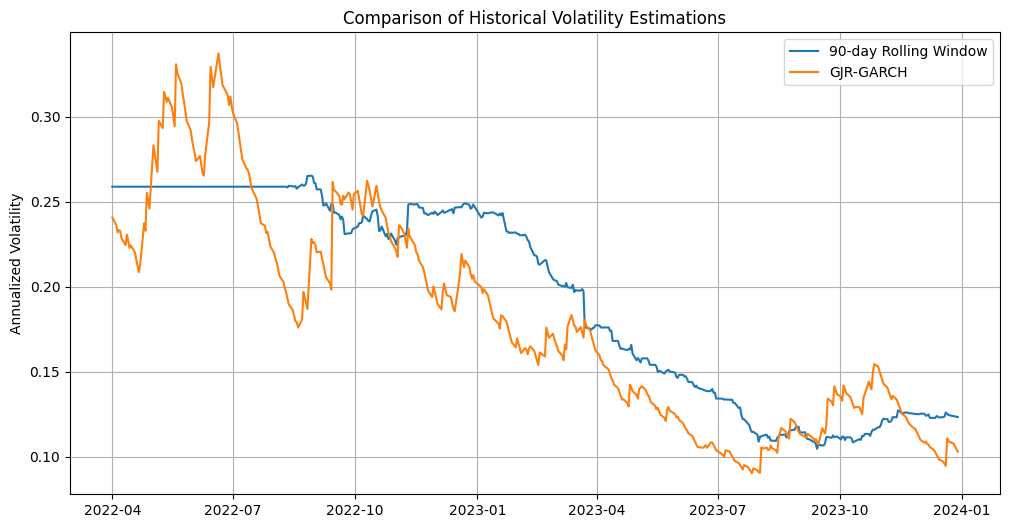

In [52]:
# Comparison of Historical Volatility Estimations
plt.figure(figsize=(12, 6))
plt.plot(df.groupby('QUOTE_DATE')['VOL_90D'].first())
plt.plot(df.groupby('QUOTE_DATE')['VOL_GG'].first())
plt.title('Comparison of Historical Volatility Estimations')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.legend(['90-day Rolling Window', 'GJR-GARCH'])
plt.show()

### Example Data Ordering for model training

In [ ]:
df = pd.read_csv("./data.csv", low_memory=False, index_col=0)

In [ ]:
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MTM,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,RFR,VOL_90D,VOL_GG,CALL,PUT
0,2022-04-01,4545.81,2022-04-01,0.0,1.0,0.0,0.0,-0.01152,0.016,,,0.000000,1 x 1,3736.20,3754.50,800.0,0.0,0.05,0 x 566,0.050000,0.0,0.0,0.00057,-0.02515,0.0,10.589610,0.000000,3745.8,0.824,0.000000,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.15,0.258858,0.240809,3745.350,0.025
1,2022-04-01,4545.81,2022-07-15,105.0,0.01341,0.0001,0.84155,-0.05319,0.16936,0.138600,0.000000,3.860000,156 x 83,1.45,1.60,5375.0,830.1,838.20,10 x 10,1061.280000,-0.9892,0.0001,0.50471,-0.06897,-15.42914,0.126870,0.000000,829.2,0.182,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.240809,1.525,834.150
2,2022-04-01,4545.81,2022-07-15,105.0,0.01449,7e-05,0.93935,-0.05841,0.19242,0.138330,0.000000,7.040000,149 x 459,1.65,1.85,5350.0,805.1,813.10,10 x 10,798.410000,-0.98975,9e-05,0.46178,-0.06581,-15.36652,0.121570,0.000000,804.2,0.177,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.240809,1.750,809.100
3,2022-04-01,4545.81,2022-07-15,105.0,0.0168,0.00011,1.02739,-0.06405,0.21393,0.136820,0.000000,2.120000,60 x 76,1.85,2.05,5325.0,776.5,792.50,20 x 40,896.170000,-0.98672,5e-05,0.64133,-0.07662,-15.25555,0.125150,0.000000,779.2,0.171,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.240809,1.950,784.500
4,2022-04-01,4545.81,2022-07-15,105.0,0.01812,0.00014,1.13223,-0.07021,0.23942,0.136170,4.000000,4.170000,125 x 91,2.05,2.35,5300.0,756.0,764.10,10 x 10,1057.990000,-0.98338,0.00012,0.86678,-0.09197,-15.13152,0.128380,0.000000,754.2,0.166,3.449692,0.15,0.37,0.53,0.71648,1.09,1.72,2.44,2.61,0.53,0.258858,0.240809,2.200,760.050


In [ ]:
def create_rolling_window_split(df, test_month, test_year=2023, 
                                         feature_columns=['STRIKE', 'UNDERLYING_LAST', 'MTM', 'RFR', 'VOLATILITY'], 
                                         train_months=8, val_months=1):
    test_start = pd.Timestamp(year=test_year, month=test_month, day=1)
    test_end = test_start + pd.offsets.MonthEnd(0)

    val_start = test_start - pd.offsets.MonthBegin(val_months)
    val_end = test_start - pd.Timedelta(days=1)

    train_start = val_start - pd.offsets.MonthBegin(train_months)  
    train_end = val_start - pd.Timedelta(days=1)

    train_df = df.loc[(df['QUOTE_DATE'] >= train_start) & (df['QUOTE_DATE'] <= train_end), ['QUOTE_DATE'] + feature_columns].set_index('QUOTE_DATE').copy()
    val_df = df.loc[(df['QUOTE_DATE'] >= val_start) & (df['QUOTE_DATE'] <= val_end), ['QUOTE_DATE'] + feature_columns].set_index('QUOTE_DATE').copy()
    test_df = df.loc[(df['QUOTE_DATE'] >= test_start) & (df['QUOTE_DATE'] <= test_end), ['QUOTE_DATE'] + feature_columns].set_index('QUOTE_DATE').copy()

    scaler = MinMaxScaler()
    scaler.fit(train_df)

    train_scaled = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
    val_scaled = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns, index=val_df.index)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

    return train_scaled, val_scaled, test_scaled

In [ ]:
training_columns = ['STRIKE', 'UNDERLYING_LAST', 'MTM', 'RFR', 'VOL_GG']

train_df, val_df, test_df = create_rolling_window_split(df, test_month=2, feature_columns=training_columns)
print(f"Length of training set: {len(train_df)}")
print(f"Length of validation set: {len(val_df)}")
print(f"Length of test set: {len(test_df)}")

Length of training set: 1371425
Length of validation set: 141741
Length of test set: 145349


In [ ]:
train_df.head()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2022-05-02,0.497802,0.794427,0.110502,0.111032,0.664165
2022-05-02,0.480769,0.794427,0.110502,0.111032,0.664165
2022-05-02,0.496703,0.794427,0.110502,0.111032,0.664165
2022-05-02,0.497253,0.794427,0.110502,0.111032,0.664165
2022-05-02,0.498901,0.794427,0.110502,0.111032,0.664165


In [ ]:
train_df.tail()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2022-12-30,0.400000,0.360917,0.022831,0.840672,0.168597
2022-12-30,0.400549,0.360917,0.022831,0.840672,0.168597
2022-12-30,0.401648,0.360917,0.022831,0.840672,0.168597
2022-12-30,0.401099,0.360917,0.022831,0.840672,0.168597
2022-12-30,0.398352,0.360917,0.022831,0.840672,0.168597


In [ ]:
val_df.head()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2023-01-04,0.098901,0.379559,0.10411,0.938108,0.147706
2023-01-04,0.120879,0.379559,0.10411,0.938108,0.147706
2023-01-04,0.142857,0.379559,0.10411,0.938108,0.147706
2023-01-04,0.164835,0.379559,0.10411,0.938108,0.147706
2023-01-04,0.186813,0.379559,0.10411,0.938108,0.147706


In [ ]:
val_df.tail()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2023-01-31,0.456044,0.686746,0.020091,0.944906,-0.039299
2023-01-31,0.461538,0.686746,0.020091,0.944906,-0.039299
2023-01-31,0.472527,0.686746,0.020091,0.944906,-0.039299
2023-01-31,0.483516,0.686746,0.020091,0.944906,-0.039299
2023-01-31,0.450549,0.686746,0.020091,0.944906,-0.039299


In [ ]:
test_df.head()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2023-02-01,0.324176,0.745391,0.108676,0.963034,-0.057619
2023-02-01,0.329670,0.745391,0.108676,0.963034,-0.057619
2023-02-01,0.335165,0.745391,0.108676,0.963034,-0.057619
2023-02-01,0.340659,0.745391,0.108676,0.963034,-0.057619
2023-02-01,0.351648,0.745391,0.108676,0.963034,-0.057619


In [ ]:
test_df.tail()

,STRIKE,UNDERLYING_LAST,MTM,RFR,VOL_GG
QUOTE_DATE,,,,,
2023-02-28,0.429121,0.538431,0.019178,0.960768,-0.041226
2023-02-28,0.429670,0.538431,0.019178,0.960768,-0.041226
2023-02-28,0.430220,0.538431,0.019178,0.960768,-0.041226
2023-02-28,0.430769,0.538431,0.019178,0.960768,-0.041226
2023-02-28,0.428571,0.538431,0.019178,0.960768,-0.041226
